# Data transformations

In this notebook, we're taking a look at some data transformations on the house price data from the Kaggle House Prices, Advanced regression techniques. (Source: kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

The utility of data transformations comes in making our data more nicely distributed for models to work on, while still maintaining structural information that the models can use to make good predictions. A simple example of a data transformation is normalisation, which sets a data field to have at maximum a norm of 1. Normalistion is necessary for many regression techniques including linear regression. We won't cover normalisation here, instead we'll look at exponential and box-cox transformations.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Import data
df_train = pd.read_csv("data/train.csv")
price = df_train.loc[:,'SalePrice']
price.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [3]:
def plot_price(price, title, set_figsize= (14,5)):
    # Create plot objects with figsize
    fig, ax = plt.subplots(1,2, figsize=set_figsize)

    # Boxplot of price
    ax[0].boxplot(price)
    ax[0].set_title(f'Boxplot of {title} distribution')

    # Histogram of price plot
    ax[1].hist(price, bins=30, alpha=0.7, color='blue', edgecolor='black', label='Histogram')
    ax[1].set_title(f'histogram of {title} distribution')

    # Plot a line graph over the histogram
    hist, bins = np.histogram(price, bins=30)
    bin_centers = (bins[:-1] + bins[1:]) / 2 # Find bin centres
    ax[1].plot(bin_centers, hist, color='green', linestyle='dashed', linewidth=2, label='Line Graph')


    # Find median and mean
    median = np.median(price)
    mean = np.mean(price)

    # Add median and mode labels
    ax[1].axvline(median, color='pink', linestyle='dashdot', linewidth=2, label='Median')
    ax[1].axvline(mean, color='purple', linestyle='dashdot', linewidth=2, label='Mean')

    fig.legend();

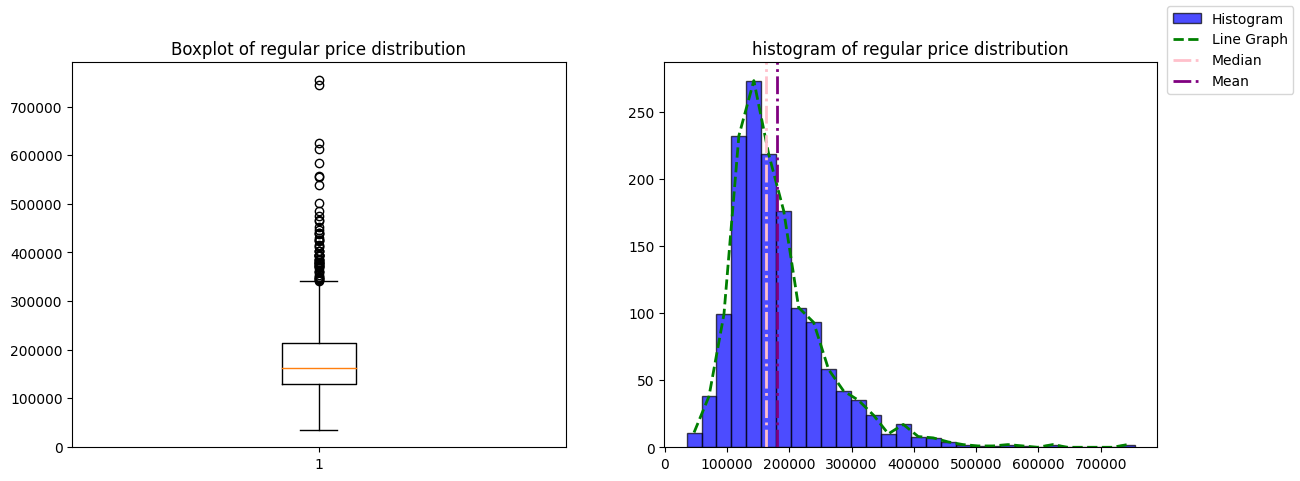

In [4]:
plot_price(price, 'regular price')

As we can see from the graphs, we have two problems:

1. Our data is positively skewed
2. We have a lot of outliers

## Dealing with Skew: Data Transformations

We can see a postive skew for our distribution. We ideally want unskewed data, so we're going to play around with some transformations to see if we can improve the distribution of the data points. Let's start with a logartihmic transformation $x$ ->$ln(x) $:

### The Log transform

Here we mean Log as in the log base $e$ (the natural logarithm).

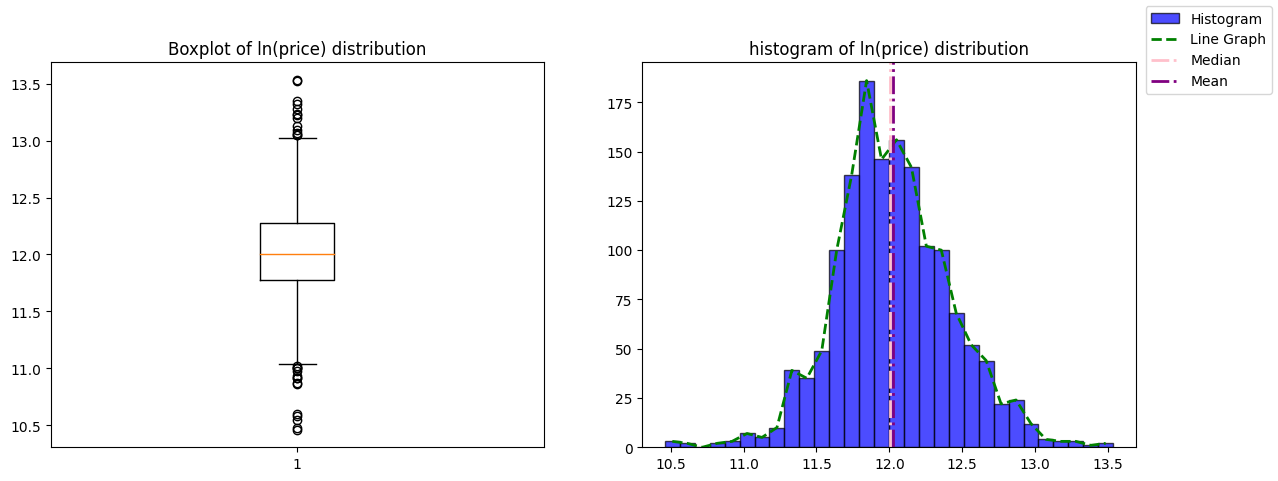

In [5]:
# Show transformed price distribution
plot_price(np.log(price), 'ln(price)')

We can instantly see that we the mean and median are much closer together which solves the skewing problem. 

From the boxplot we can also see there are now outliers above and below the distribution, let's compare outliers in the two data sets


In [6]:
# Find number of outliers
def calculate_outliers(data):
    
    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find the data points outside the IQR
    outliers_below = (data < lower_bound)
    outliers_above = (data > upper_bound)

    # Calculate the proportion of data points outside the IQR
    proportion_outliers = (np.sum(outliers_below) + np.sum(outliers_above)) / len(data)



    print("Proportion of data points outside IQR:", proportion_outliers, 
          '\nThis equals', proportion_outliers*100,'%')

    print(f"Outliers above: {np.sum(outliers_above)} \nOutliers below: {np.sum(outliers_below)}")

In [7]:
calculate_outliers(price)

Proportion of data points outside IQR: 0.04178082191780822 
This equals 4.178082191780822 %
Outliers above: 61 
Outliers below: 0


In [8]:
calculate_outliers(np.log(price))

Proportion of data points outside IQR: 0.019178082191780823 
This equals 1.9178082191780823 %
Outliers above: 13 
Outliers below: 15


## Applications to predictions

Now, this transformation may make our data look nicer, but does it actually have an effect on what we can do? Luckily, the answer is yes. This is because we have an inverse transformation: the exponential $e^x$

You can find places where $ln(x)$ is specifically defined as the inverse function to the exponential, i.e.  $ln(e^x) = x$ for all $x$

We also have $ln(e^x) = x$ for all $x>0$. This is because $e^x$ is always stricly positive ($e^x>0$ so it wouldn't make sense for it's inverse function $ln(x)$ to output anything that is smaller than or equal to $0$. 

(Practically, this means that we can't use our $ln(x)$ transformation for data with negative values.)

With this knowledge, we can actually redefine our machine learning problem. The trick is to try to predict log(price) rather than price.

I'll outline the approach in several steps:

0. We want to find to a prediction of price. (but the data is skewed)
1. We apply the natural logarithm $ln(x)$ to our price data to get log(price)
2. We then train our machine learning regression model to predict log(price) based on our dependent variables
3. We use our model on the test set's dependent variables to predict log(price_test) and we save this in log(price_test_predictions)
4. We apply $e^x$ to log(price_test_predictions) to obtain price_test_predictions

This method "sidesteps" having to train a model on skewed data while still maintaining useful strucutral information about the data that our model can learn from.

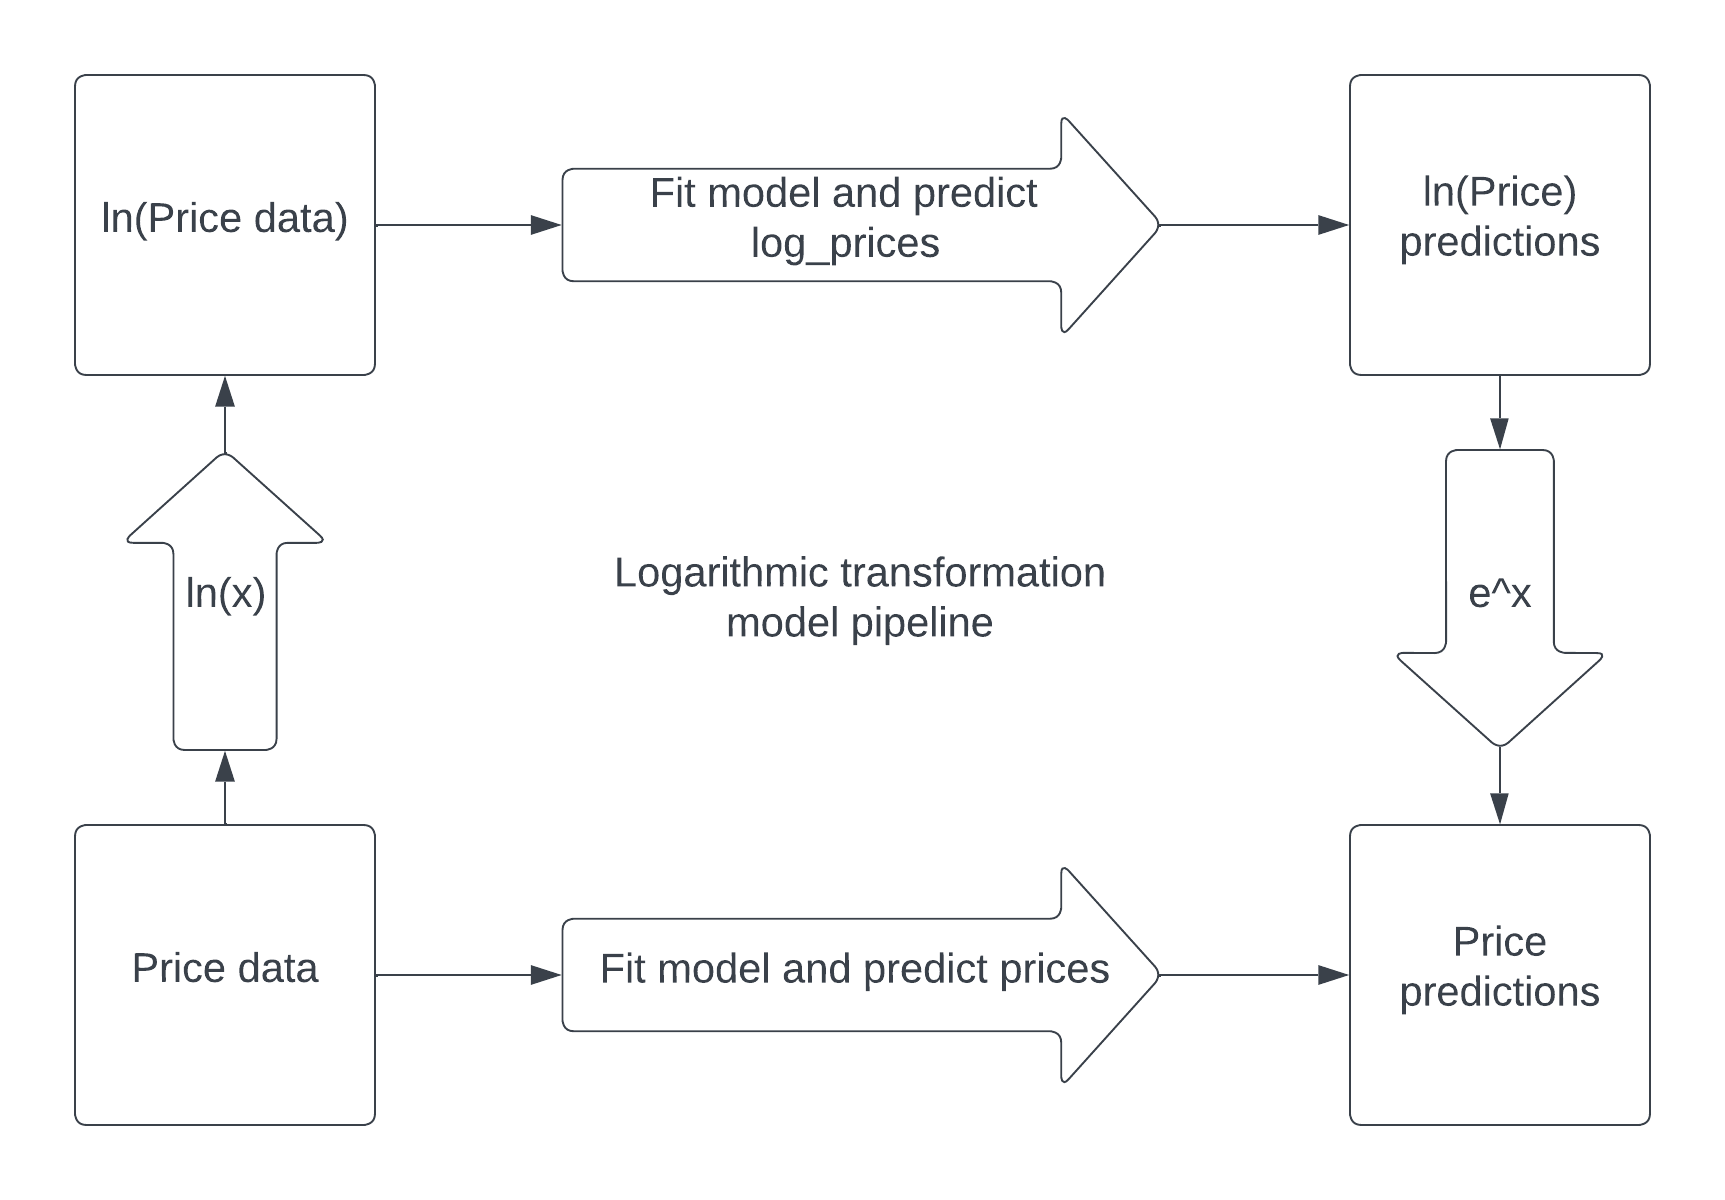

## Box cox transformation

Another common transformation is the box-cox transformation. Different values of lambda lead to different transformations:

* λ = 0: The logarithm transformation.
* λ = 1: No transformation (identity transformation).
* λ > 0: Power transformation (positive values make the data more normal).
* λ < 0: Reciprocal transformation (negative values make the data more normal).

as you can see, box-cox(0) is the same as the logarithmic transformation so we can obtain at least the same result as we did before - but we'll look to improve on it.

The expicit formula is as follows:

$f(x,\lambda)$ is defined as:

* $ln(x)$ if $\lambda = 0$
* $(x^{\lambda} -1)/\lambda$ if $\lambda \neq 0$


In [9]:
# Define box cox function
def box_cox(x, lam=0):
    x = x.astype('float') 
    if lam == 0:
        return np.log(x)
    else:
        return (np.power(x,lam) - 1)/lam

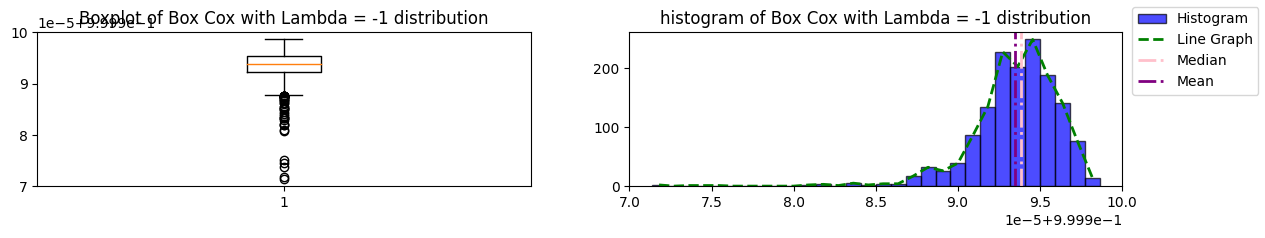

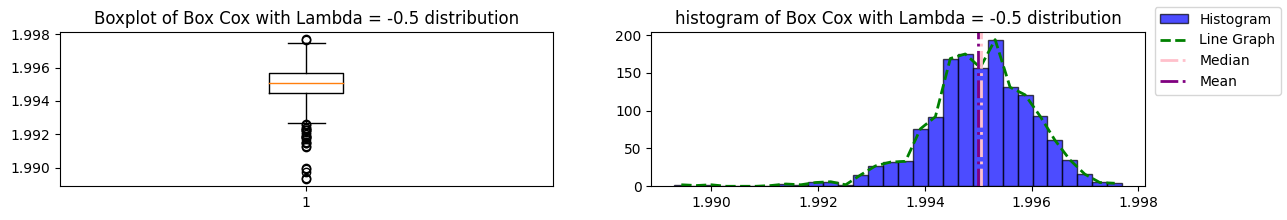

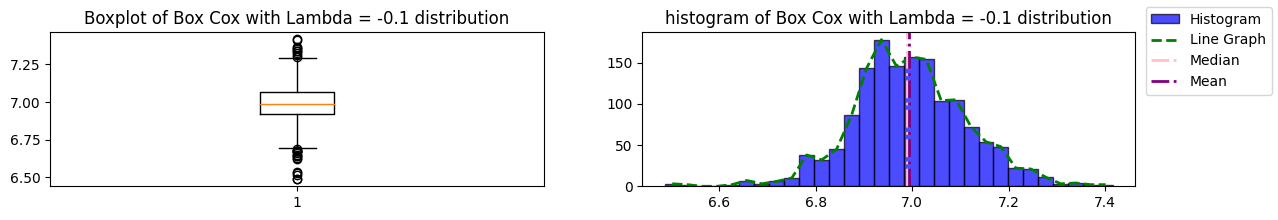

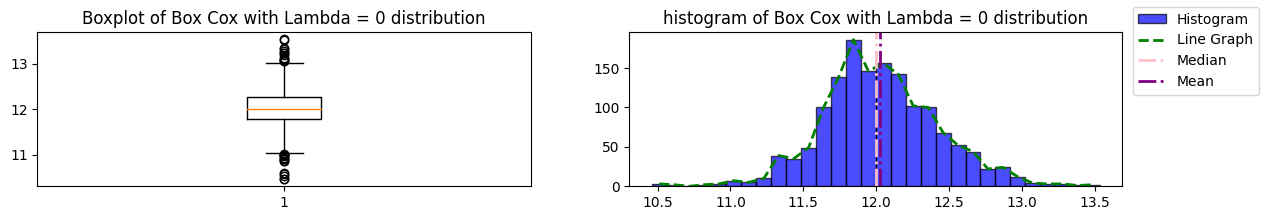

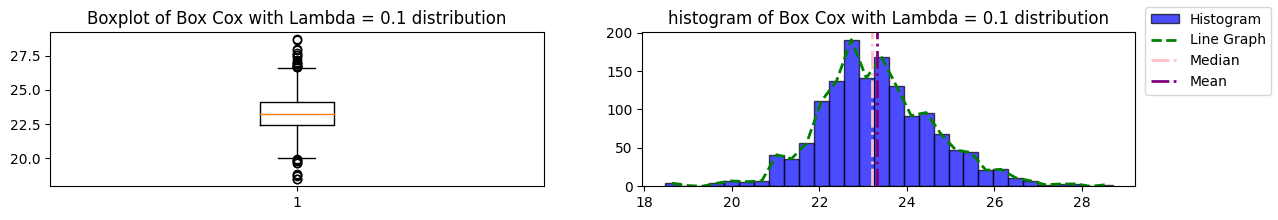

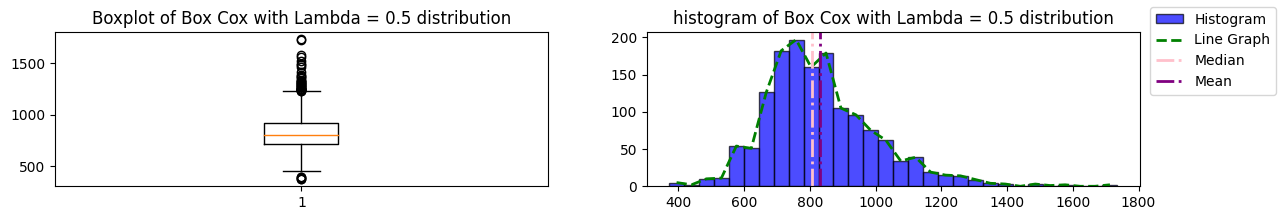

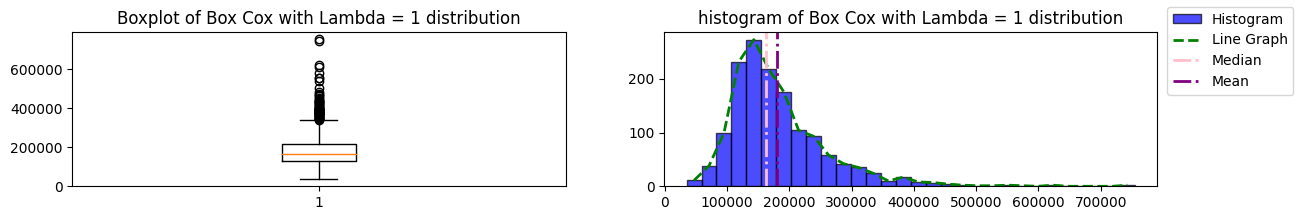

In [10]:
# Plot the data
for lam_val in [-1,-0.5,-0.1,0,0.1,0.5,1]:
    #store transformed data
    plot_price(box_cox(price, lam=lam_val), f'Box Cox with Lambda = {lam_val}', set_figsize = (14,2))

    

We can see in these graphs how lambda directly influences the skew of the data. The median and mean don't seem to separate much for our values of lambda, but the location of outliers varies significantly.

We can also note the dramatic increases in magnitude of the values we are working with. This may mean that we could require post-transformation normalisation for certain models and that for extreme values of lambda we may have to consider memory constraints for our data arrays.

In [11]:
# Show outlier behaviour:
print("Outlier distribution across values of lambda:")

for lam_val in [-1,-0.5,-0.1,0,0.1,0.5,1]:
    print(f"\nLambda = {lam_val}")
    calculate_outliers(box_cox(price, lam=lam_val))


Outlier distribution across values of lambda:

Lambda = -1
Proportion of data points outside IQR: 0.02945205479452055 
This equals 2.945205479452055 %
Outliers above: 0 
Outliers below: 43

Lambda = -0.5
Proportion of data points outside IQR: 0.01780821917808219 
This equals 1.7808219178082192 %
Outliers above: 2 
Outliers below: 24

Lambda = -0.1
Proportion of data points outside IQR: 0.01780821917808219 
This equals 1.7808219178082192 %
Outliers above: 10 
Outliers below: 16

Lambda = 0
Proportion of data points outside IQR: 0.019178082191780823 
This equals 1.9178082191780823 %
Outliers above: 13 
Outliers below: 15

Lambda = 0.1
Proportion of data points outside IQR: 0.01986301369863014 
This equals 1.9863013698630139 %
Outliers above: 18 
Outliers below: 11

Lambda = 0.5
Proportion of data points outside IQR: 0.030821917808219176 
This equals 3.0821917808219177 %
Outliers above: 40 
Outliers below: 5

Lambda = 1
Proportion of data points outside IQR: 0.04178082191780822 
This equa

We actually end up with one fewer outlier point for the value $\lambda = -0.1$ when compared to the logarithmic transformation ($\lambda = 0$). It does however give more of a bias toward outliers below than above so it's not better in every way for this dataset - it just gives us a different method to use when appropriate.

Like with the logarithmic transformation, we have an inverse transformation for the box-cox: 

this is defined as:

$g(y,\lambda)$ is defined as:

* $e^y$ if $\lambda = 0$
* $(y * \lambda + 1)^{\frac{1}{\lambda}}$ if $\lambda \neq 0$

With this we can use the same method as we did before to use this to train models on.

## Comparing our transformations to the gaussian distribution: Q-Q plots

We want to compare our transformed data to a gaussian distribution. One tool to do this is a Q-Q plot.

A Q-Q (Quantile-Quantile) plot works by plotting the quantiles of the dataset against the quantiles of the theoretical distribution. If the points on the plot fall roughly along a straight line, it indicates a good match between the data and the theoretical distribution. Deviations from the line reveal differences in shape, such as skewness or heavy tails.

We'll look at the "normality" of our untampered "price" column, alongside our log(price) and box_cox(price) with $\lambda$ = -0.1

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats



def plot_QQ(Data, title='something'):
    # Generate theoretical quantiles for the normal distribution around the data's mean and std
    theoretical_quantiles = (stats.norm.ppf(np.linspace(0.01, 0.99, 100)) *np.std(Data)) + Data.mean()

    # Sort the data and calculate empirical quantiles
    sorted_data = np.sort(Data)
    empirical_quantiles = np.percentile(sorted_data, np.linspace(1, 99, 100))

    # Create the Q-Q plot
    plt.figure(figsize=(8, 6))
    plt.scatter(theoretical_quantiles, empirical_quantiles, color='blue', label='Data')
    plt.plot(theoretical_quantiles, theoretical_quantiles, color='red', label='Theoretical')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Empirical Quantiles')
    plt.title(f'Q-Q Plot of {title}')
    plt.legend()
    plt.grid(True)
    plt.show()


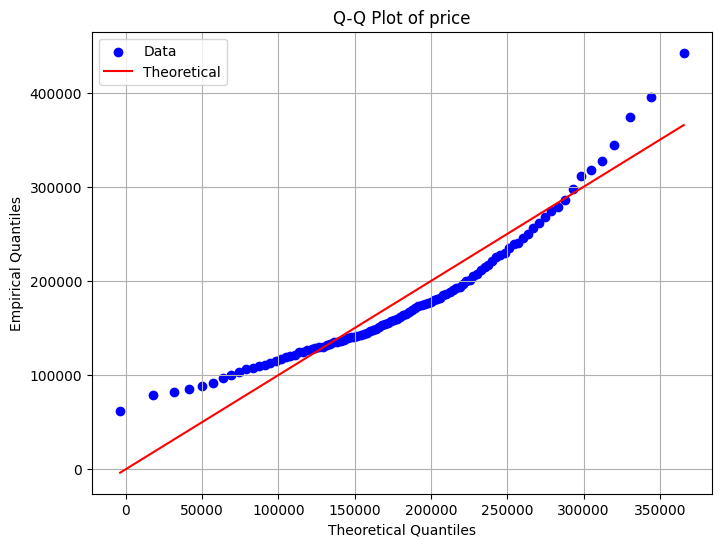

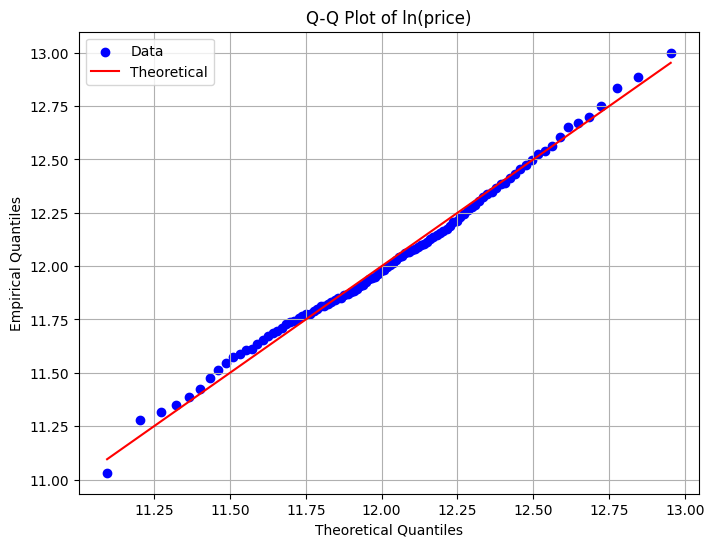

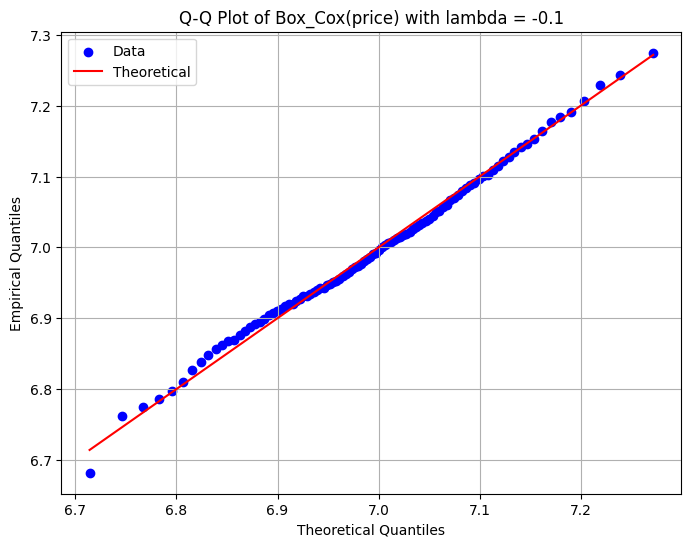

In [13]:
plot_QQ(price, 'price')
plot_QQ(np.log(price), 'ln(price)')
plot_QQ(box_cox(price,lam=-0.1), 'Box_Cox(price) with lambda = -0.1')

These plots are quite cool and show exhibits that the data conforms the normal distribution after our two transformations.

I'll also quantify the difference in absolute value of the empirical and theoretical quantiles - this is not a perfect method, but it should at least give us some numbers to go with the graph.

In [14]:
def quantile_deviation(Data):
    '''
    :param: Data - np.array
    Returns MSE and MAE
    '''
    # Generate theoretical quantiles for the normal distribution around the data's mean and std
    theoretical_quantiles = (stats.norm.ppf(np.linspace(0.01, 0.99, 100)) *np.std(Data)) + Data.mean()

    # Sort the data and calculate empirical quantiles
    sorted_data = np.sort(Data)
    empirical_quantiles = np.percentile(sorted_data, np.linspace(1, 99, 100))
    # We divide by empirical_quantiles to "normalise" - this is bad maths, but I can't work the python easily
    return  np.sum(((theoretical_quantiles - empirical_quantiles)/np.maximum(theoretical_quantiles, empirical_quantiles))**2), np.sum(np.abs((theoretical_quantiles - empirical_quantiles)/np.maximum(theoretical_quantiles, empirical_quantiles)))

print('MSE:',quantile_deviation(price)[0], quantile_deviation(np.log(price))[0], quantile_deviation(box_cox(price,lam=-0.1))[0])
print('MAE:',quantile_deviation(price)[1], quantile_deviation(np.log(price))[1], quantile_deviation(box_cox(price,lam=-0.1))[1])

MSE: 3.848874028247169 0.0006745393875978884 0.00014253313105955516
MAE: 12.45044803190067 0.22280854414858073 0.09441762357688017


In [32]:
from tabulate import tabulate

# Sample data
data = [
    ["Original", quantile_deviation(price)[0], quantile_deviation(price)[1]],
    ["Log", quantile_deviation(np.log(price))[0], quantile_deviation(np.log(price))[1]],
    ["Box-Cox", quantile_deviation(box_cox(price,lam=-0.1))[0], quantile_deviation(box_cox(price,lam=-0.1))[1]]
]

# Headers for the table
headers = ["Transformation", "MSE", "MAE"]

# Print the table
table = tabulate(data, headers=headers, tablefmt="fancy_grid")
print(table)



╒══════════════════╤═════════════╤════════════╕
│ Transformation   │         MSE │        MAE │
╞══════════════════╪═════════════╪════════════╡
│ Original         │ 3.84887     │ 12.4504    │
├──────────────────┼─────────────┼────────────┤
│ Log              │ 0.000674539 │  0.222809  │
├──────────────────┼─────────────┼────────────┤
│ Box-Cox          │ 0.000142533 │  0.0944176 │
╘══════════════════╧═════════════╧════════════╛


I'll end this here for now, I hope you found it enlightening and/or helpful. Feel free to give any feedback or criticism :)